# Exploring how the 2-layer model with a temperature dependent gamma behaves

Let's look at some of the familiar idealized forcing scenarios to see if the model still works when the temp. difference goes negative. Basically, let's perform a sanity check.

So plan:
1.   positive followed by negative triangular forcing
1.   top hat forcing of widths 5,50,200 years 
1.   triangular forcing of widths 5,50,200 years
1.   oscillatory tophat forcing of widths 5,50,200 years (adjust so same wavelength as pulsed forcing )
1.   oscillatory triangular forcing of widths 5,50,200 years (adjust so same wavelength as pulsed forcing)

Then we will test a range of kappas -> Important!

In [2]:
import json
import numpy as np
import matplotlib.pyplot as plt
from fair.constants import molwt
from fair.forcing.ghg import etminan, meinshausen
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
import scipy.stats as sty
import random
import pandas as pd
from tqdm import tqdm
import random
import os

from ar6.utils import check_and_download, mkdir_p
from ar6.utils.statistics import weighted_percentile
from ar6.utils.h5 import *
from ar6.utils import mkdir_p
from ar6.constants.gases import ghg_to_rcmip_names
from ar6.forcing.aerosol import ghan, aerocom_n
from ar6.forcing.ozone import eesc
from ar6.constants.gases import rcmip_to_ghg_names, ghg_to_rcmip_names, ods_species, radeff
from multiprocessing import Pool

from ar6.twolayermodel import TwoLayerModel
from ar6.constants import NINETY_TO_ONESIGMA

### 1)Positive followed by negative triangular forcing, compare with meeting notes
Right now we are simply using kappa = 0.3
For this we will have a wavelength of 200 years. Amplitude of 4xCO2 See signal below.


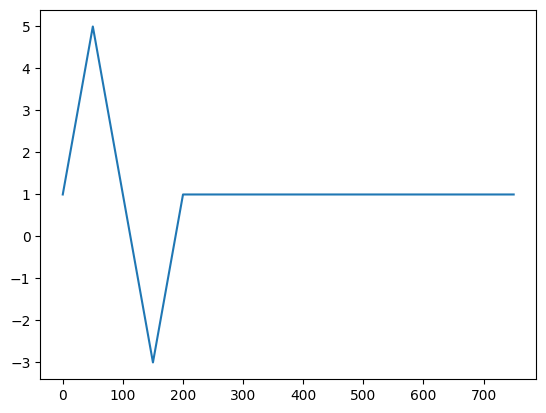

In [3]:
runs = {}
xs = np.arange(751) 
xs = xs * 4/50

xs[50:151] = xs[50:151]* -1

xs[50:151] = xs[50:151] + 8 
xs[151:201] = xs[151:201] - 16
xs += 1
xs[200:] = 1

triang_pulse = xs
plt.plot(xs)
#need to run cell above
steps = [triang_pulse]
step_names = ["Triangular Pulse"]

In [4]:
for (step, name) in zip(steps, step_names):
    print(f"currently on %s... "%name)
    for i in tqdm(range(1000)):   # 5x as fast as fair, 10x as fast as openscm-runner
        scm = TwoLayerModel(
            extforce= step,
            exttime=np.arange(1750,2501),
            tbeg=1750,
            tend=2501,
            lamg=4.0/3.0,
            t2x=None,
            eff=1.29,
            cmix=6,
            cdeep=75,
            gamma_2l=0.7,
            kappa=0.3, 
            outtime=np.arange(1750.5,2501),
            dt=3
        )
        
        out = scm.run()
    runs[name] = out

currently on Triangular Pulse... 


100%|██████████| 1000/1000 [00:22<00:00, 43.73it/s]


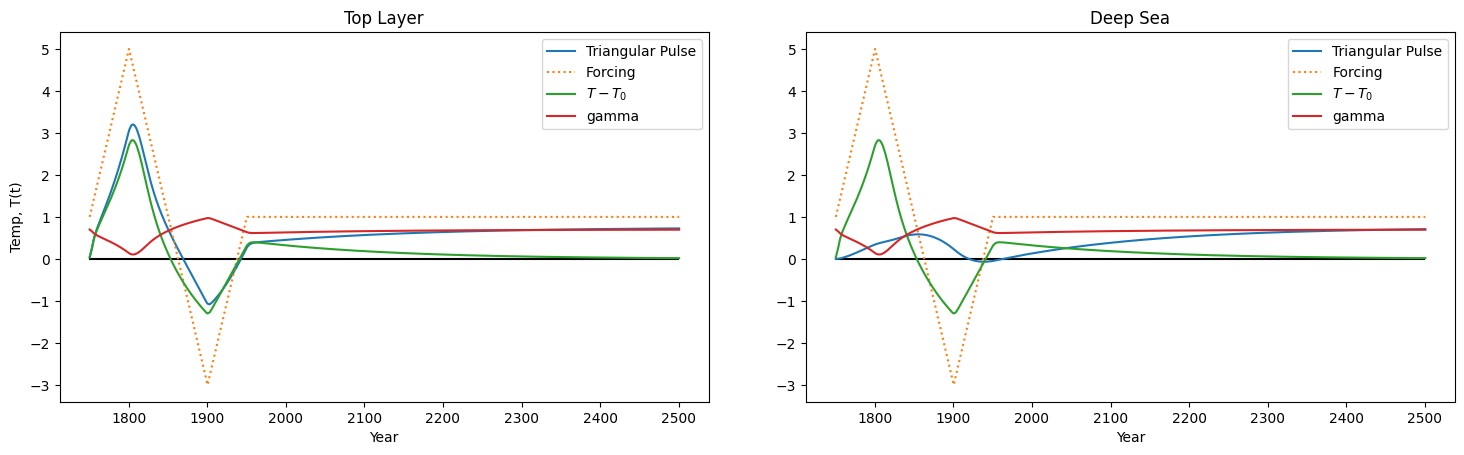

In [9]:
fig, axs = plt.subplots(1,2)
fig.subplots_adjust(wspace=0.15); fig.set_figwidth(18)
axs[0].set_ylabel('Temp, T(t)');


scenario_names = runs.keys()
run_outputs = runs.values()

layers = ["Top Layer", "Deep Sea"]

for (run, scen) in zip (run_outputs, scenario_names):
    for (subpl, col, layer) in zip(axs, [0,1], layers):
        if col == 0:
            subpl.plot(run.time, run.tg, label = scen)
        else:
             subpl.plot(run.time, run.tlev[:,1], label = scen)
        subpl.title.set_text(layer)
        subpl.set_xlabel('Year')
        subpl.plot(run.time,triang_pulse, linestyle = "dotted", label="Forcing")
        subpl.plot(run.time, (run.tg- run.tlev[:,1]), label = "$T-T_0$")
        subpl.plot(run.time[::3], run.gammas, label = "gamma") #The 3 is there to match the timestep
        subpl.hlines(0, 1750, 2500, 'k')
    
    
for subpl in axs:
     
    subpl.legend()

In [13]:
for i in tqdm(range(1000)):   # 5x as fast as fair, 10x as fast as openscm-runner
    scm = TwoLayerModel(
        extforce= step,
        exttime=np.arange(1750,2501),
        tbeg=1750,
        tend=2501,
        lamg=4.0/3.0,
        t2x=None,
        eff=1.29,
        cmix=6,
        cdeep=75,
        gamma_2l=0.7,
        kappa=0, 
        outtime=np.arange(1750.5,2501),
        dt=3
    )
        
    out0 = scm.run()
runs["Kappa = 0, Triangular Pulse"] = out0


100%|██████████| 1000/1000 [00:21<00:00, 45.99it/s]


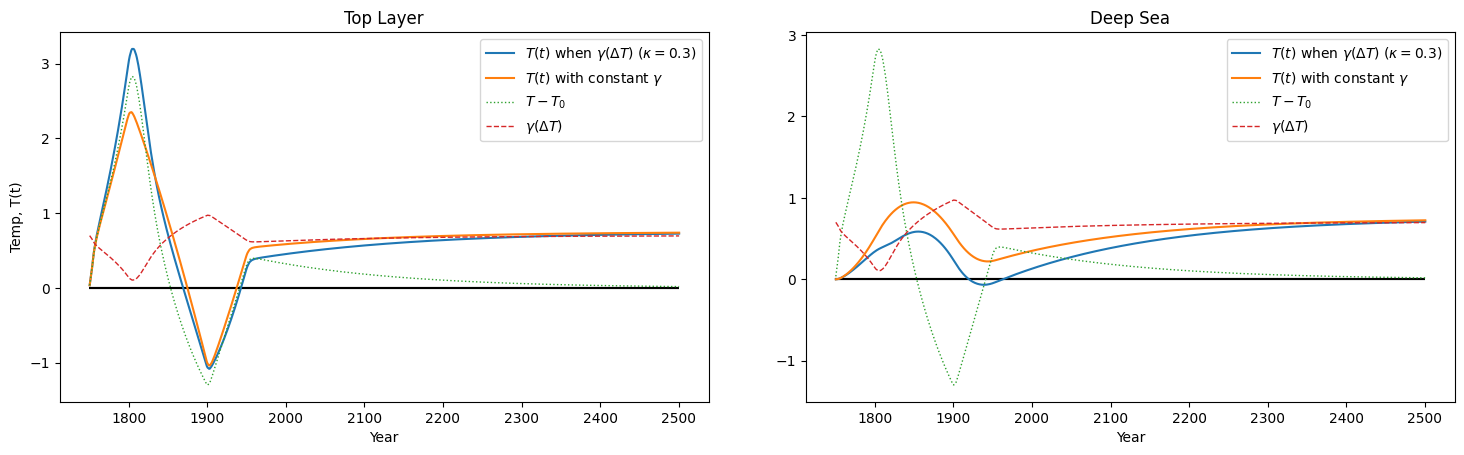

In [27]:
fig, axs = plt.subplots(1,2)
fig.subplots_adjust(wspace=0.15); fig.set_figwidth(18)
axs[0].set_ylabel('Temp, T(t)');


scenario_names = runs.keys()
run_outputs = runs.values()

layers = ["Top Layer", "Deep Sea"]
labels = ["$T(t)$ when $\gamma (\Delta T)$ ($\kappa = 0.3$)", "$T(t)$ with constant $\gamma$"]

for (run, label) in zip (run_outputs, labels):
    for (subpl, col, layer) in zip(axs, [0,1], layers):
        if col == 0:
            subpl.plot(run.time, run.tg, label = label)
        else:
             subpl.plot(run.time, run.tlev[:,1], label = label)
        subpl.title.set_text(layer)
        subpl.set_xlabel('Year')
        #subpl.plot(run.time,triang_pulse, linestyle = "dotted", label="Forcing")
        
        
        subpl.hlines(0, 1750, 2500, 'k')
    
    
for subpl in axs:
    out1  = runs["Triangular Pulse"]
    subpl.plot(out1.time, (out1.tg- out1.tlev[:,1]), label = "$T-T_0$", linestyle = "dotted", linewidth = 1)
    subpl.plot(out1.time[::3], out1.gammas, label = "$\gamma (\Delta T)$",linestyle = "dashed", linewidth = 1) #The 3 is there to match the timestep
    subpl.legend()

Is this what we expect? Positive temperature difference corresponds to a gamma smaller than $\gamma_0$. This means that heat transfer is smaller, as stability increases. A negative $\Delta T$ then corresponds to $\gamma > \gamma_0$ -  decreasing stability. Increased stability, $\gamma < \gamma_0$, when warming of top layer is occuring, should mean that the effect of a non-constant gamma results in decreased warming of bottom layer, something which is indeed reproduced.  